### Imports

In [1]:
# Clone the GitHub repository
!git clone https://github.com/Rezaei-Parham/Tennis-3DVision-Project.git


Cloning into 'Tennis-3DVision-Project'...
remote: Enumerating objects: 149, done.
remote: Total 149 (delta 0), reused 0 (delta 0), pack-reused 149
Receiving objects: 100% (149/149), 41.92 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [2]:
# Unzip the cloned repository
!unzip Tennis-3DVision-Project.zip


unzip:  cannot find or open Tennis-3DVision-Project.zip, Tennis-3DVision-Project.zip.zip or Tennis-3DVision-Project.zip.ZIP.


In [3]:

# Copy the contents of the cloned folder to the original location
!cp -r /content/Tennis-3DVision-Project/* /content/

# Delete the original folder
!rm -r /content/Tennis-3DVision-Project


In [4]:
!pip install black


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:00


In [5]:
import shutil
import importlib
import cv2
shutil.rmtree('__pycache__')
import Player
importlib.reload(Player)
from Player import get_player_boxes
from Ball import BallDetector
import detect_court_net
import Transmit
import matplotlib.pyplot as plt
import numpy as np
import random

read the video by the videostream class

In [6]:
path_to_video = 'cocog.mp4'

In [7]:
vs = Transmit.VideoStream()
frames = vs.read_video(path_to_video)

load the balls and initiate the ball detector

In [8]:
bd = BallDetector(path_weights='weights/model.3')

layer24 output shape: 256 360 640
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 360, 640)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 360, 640)      5248      
                                                                 
 activation (Activation)     (None, 64, 360, 640)      0         
                                                                 
 batch_normalization (Batch  (None, 64, 360, 640)      2560      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 360, 640)      36928     
                                                                 
 activation_1 (Activation)   (None, 64, 360, 640)      0         
                         

setting the resolution of video

In [9]:
bd.output_height = vs.output_height
bd.output_width = vs.output_width

detect balls

In [10]:
ballpoints = bd.find_ball_points(frames)
ballpoints = bd.postprocess_points(ballpoints)
# bd.draw_trajectory_pride(frames, ballpoints, 'balltestonly.mp4') #if you need to only see the balls

1/1 [==============================] - 0s 25ms/step


find players

In [11]:
players = Player.get_player_boxes(frames)

just see the transmitted version

In [12]:
courtpoints = detect_court_net.detect_points(frames[1], False)
# img = detect_court_net.detect_points(frames[1], True)
# print(courtpoints, frames[0].shape, len(frames))
print(courtpoints)

([[373, 147], [373, 218], [374, 698], [374, 628], [275, 257], [277, 424], [278, 592], [115, 287], [114, 321], [111, 564], [112, 529], [149, 307], [148, 425], [147, 542], [169, 425]], [[166, 255], [167, 594]])


In [13]:
print(len(players), len(ballpoints), len(frames), frames[0].shape)
print(players[0], ballpoints[0], courtpoints)

192 193 193 (480, 854, 3)
[(335, 292, 40, 62), (506, 64, 25, 40)] [375, 295] ([[373, 147], [373, 218], [374, 698], [374, 628], [275, 257], [277, 424], [278, 592], [115, 287], [114, 321], [111, 564], [112, 529], [149, 307], [148, 425], [147, 542], [169, 425]], [[166, 255], [167, 594]])


In [14]:
while len(players) != len(frames):
    players.insert(0, [])

In [15]:
print(path_to_video, frames[0].shape)

cocog.mp4 (480, 854, 3)


In [16]:
cap = cv2.VideoCapture(path_to_video)
fourcc = cv2.VideoWriter_fourcc('H','2','6','4')
out = cv2.VideoWriter("gg_ff_out.mp4", fourcc, cap.get(cv2.CAP_PROP_FPS), (frames[0].shape[1],frames[0].shape[0]))
for i, frame in enumerate(frames):
    for bbox in players[i]:
        Player.drawBox(frame, bbox)
    # print(i, ballpoints[i][0])
    Player.drawBox(frame, (ballpoints[i][0], ballpoints[i][1], 10, 10))
    keypoints, netpoints = courtpoints
    for point in keypoints + netpoints:
        Player.drawBox(frame, (point[1], point[0], 10, 10))

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

[[373, 147], [373, 218], [374, 698], [374, 628], [275, 257], [277, 424], [278, 592], [115, 287], [114, 321], [111, 564], [112, 529], [149, 307], [148, 425], [147, 542], [169, 425], [166, 255], [167, 594]] 17


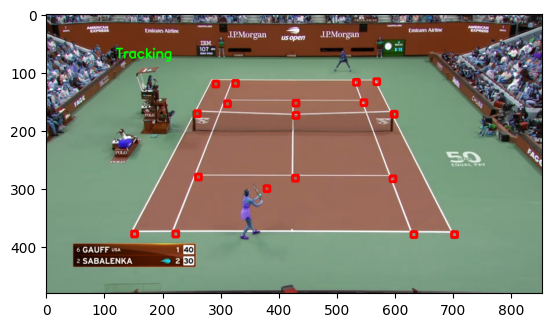

In [17]:
plt.imshow(frames[0])
all_courtpoints = courtpoints[0] + courtpoints[1]
print(all_courtpoints, len(all_courtpoints))

In [18]:
path_2d_court = 'tennis_2d_3.png'

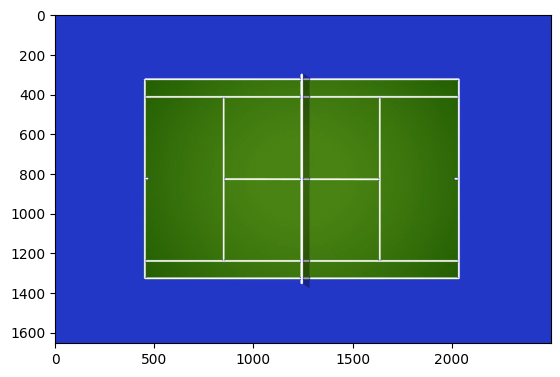

In [19]:
img = cv2.imread(path_2d_court)
plt.imshow(img[:,:,::-1])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
img[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(img)
# print((dst>0.01*dst.max()).shape)
kpts = np.argwhere(dst>0.01*dst.max())
# print(len(kpts))

In [20]:
# all_court2dpoints = [[67, 63] , [138, 63] , [545, 63], [474, 63] , [138, 288], [306, 288],
#                  [474, 288] , [67, 960], [138, 960], [545, 960], [474, 960], [138, 738],
#                  [306, 738] , [474, 738], [306, 512], [67, 512], [545 , 512]]
# all_court2dpoints = [[74, 61] , [106, 61] , [324, 61], [287, 61] , [106, 148], [199, 148],
                 # [287, 148] , [74, 549], [106, 549], [324, 549], [287, 549], [106, 462],
                 # [199, 462] , [287, 462], [199, 306], [74, 306], [324 , 306]]
all_court2dpoints = [[327, 453] , [416, 453] , [1329, 453], [1241, 453] , [416, 851], [830, 851],
                 [1241, 851] , [327, 2034], [416, 2034], [1329, 2034], [1241, 2034], [416, 1638],
                 [830, 1638] , [1241, 1638], [830, 1244], [327, 1244], [1329 , 1244]]

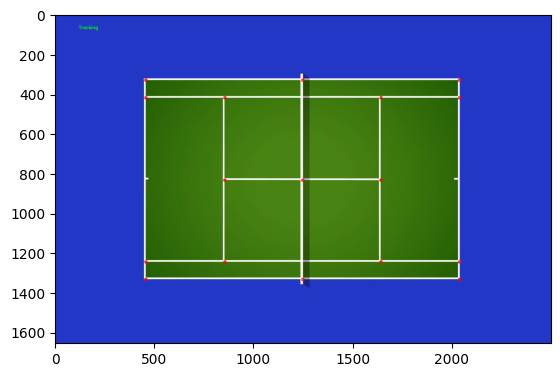

In [21]:
img = cv2.imread(path_2d_court)
for pt in all_court2dpoints:
    Player.drawBox(img, (pt[1], pt[0], 10, 10))
plt.imshow(img)

In [22]:
np_all_courtpoints = np.array(all_courtpoints)
np_all_court2dpoints = np.array(all_court2dpoints)

# zipped_points = list(zip(all_courtpoints, all_court2dpoints))
# random.shuffle(zipped_points)
# np_all_courtpoints, np_all_court2dpoints = zip(*zipped_points)
# np_all_courtpoints = np.array(np_all_courtpoints)
# np_all_court2dpoints = np.array(np_all_court2dpoints)

# np_all_court2dpoints[:,1] -= 30

H, _ = cv2.findHomography(np_all_courtpoints, np_all_court2dpoints)
print(H)

[[ 1.13632477e+01  1.08868438e+01 -3.71404379e+03]
 [-9.33051847e+00  2.39720838e-01  6.23031301e+03]
 [ 1.34993243e-02  2.82190874e-04  1.00000000e+00]]


In [31]:
"""import cv2
import numpy as np

# Read the video
video_path = '/content/cocog.mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties
width = int(cap.get(3))
height = int(cap.get(4))

# Calculate size of the square video
size = width + height

# Create a black square video
black_square = np.zeros((size, size, 3), dtype=np.uint8)

# Calculate position to paste the original video in the center
x_offset = (size - width) // 2
y_offset = (size - height) // 2

# Read each frame, resize it to fit in the square, and paste onto the black square
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to fit in the square
    resized_frame = cv2.resize(frame, (width, height))

    # Paste resized frame onto black square
    black_square[y_offset:y_offset+height, x_offset:x_offset+width, :] = resized_frame
    frames.append(black_square.copy())

cap.release()

# Save the resized video
output_path = '/content/cocog_resized.mp4'
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (size, size))

for frame in frames:
    out.write(frame)

out.release()
"""

In [101]:
import cv2
import numpy as np

# Input and output file paths
input_path = '/content/adv.mp4'
output_path = '/content/result.avi'

# Read the video file to get dimensions
cap = cv2.VideoCapture(input_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Homography matrix H
H, _ = cv2.findHomography(np_all_courtpoints, np_all_court2dpoints)

# Get the affine transformation matrix P
P = H[:2, :]
print("Affine Transformation Matrix (P) before rotation:")
print(P)

# Rotate the affine transformation matrix P by 90 degrees clockwise
rotation_matrix = np.array([[0, 1],
                            [-1, 0]])
P_rotated = np.column_stack([rotation_matrix @ P[:, :2].T, P[:, 2]])

# Print the updated affine transformation matrix P
print("\nUpdated Affine Transformation Matrix (P) after rotation:")
print(P_rotated)

# Define the four corners of the input video
input_corners = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

# Map the corners using warpAffine for an affine transformation
output_corners = cv2.transform(input_corners.reshape(1, -1, 2), P_rotated).reshape(-1, 2)

# Calculate translation and scaling factors
min_x, min_y = np.min(output_corners, axis=0)
max_x, max_y = np.max(output_corners, axis=0)

translation = np.array([min_x, min_y])
scale = np.array([width / (max_x - min_x), height / (max_y - min_y)])

# Apply translation and scaling to the affine transformation matrix P
P_rotated[0, 2] -= translation[0]
P_rotated[1, 2] -= translation[1]
P_rotated[0, :] *= scale[0]
P_rotated[1, :] *= scale[1]

# Print the updated affine transformation matrix P
print("\nUpdated Affine Transformation Matrix (P) after translation and scaling:")
print(P_rotated)

# Apply translation and scaling to the mapped corners
output_corners -= translation
output_corners *= scale

# Ensure that the updated mapped corners fit within the output frame
min_x, min_y = np.min(output_corners, axis=0)
max_x, max_y = np.max(output_corners, axis=0)

translation_correction = np.zeros(2)
if min_x < 0:
    translation_correction[0] = -min_x
elif max_x > width:
    translation_correction[0] = width - max_x

if min_y < 0:
    translation_correction[1] = -min_y
elif max_y > height:
    translation_correction[1] = height - max_y

output_corners += translation_correction

# Print the final mapped corner locations
print("\nFinal Mapped Corner Locations:")
for i, corner in enumerate(output_corners):
    print(f"Corner {i+1}: ({corner[0]}, {corner[1]})")

# Release video capture
cap.release()

# Re-read the video file for processing
cap = cv2.VideoCapture(input_path)

# Create VideoWriter object for the output
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter(output_path, fourcc, int(cap.get(cv2.CAP_PROP_FPS)), (width, height), isColor=True)

# Process each frame
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Apply affine transformation to the frame
    transformed_frame = cv2.warpAffine(frame, P_rotated, (width, height))

    # Draw transparent points on a separate image
    points_image = np.zeros_like(frame, dtype=np.uint8)
    for point in output_corners:
        cv2.circle(points_image, tuple(point.astype(int)), 5, (0, 255, 0), -1)  # Green circle

    # Overlay the points image on the transformed frame
    alpha = 0.5  # Adjust transparency
    overlay = cv2.addWeighted(transformed_frame, 1 - alpha, points_image, alpha, 0)

    # Write the frame with transparent points to the output video
    out.write(overlay)

# Release video capture and writer
cap.release()
out.release()

print(f"Transformation complete. Result saved to {output_path}")


Affine Transformation Matrix (P) before rotation:
[[ 1.13632477e+01  1.08868438e+01 -3.71404379e+03]
 [-9.33051847e+00  2.39720838e-01  6.23031301e+03]]

Updated Affine Transformation Matrix (P) after rotation:
[[ 1.08868438e+01  2.39720838e-01 -3.71404379e+03]
 [-1.13632477e+01  9.33051847e+00  6.23031301e+03]]

Updated Affine Transformation Matrix (P) after translation and scaling:
[[ 9.87765685e-01  2.17499234e-02 -7.93691464e-06]
 [-3.84779447e-01  3.15947680e-01  2.46258847e+02]]

Final Mapped Corner Locations:
Corner 1: (0.0, 246.25885009765625)
Corner 2: (632.1700439453125, 0.0)
Corner 3: (640.0, 113.74117279052734)
Corner 4: (7.829977989196777, 360.0)
Transformation complete. Result saved to /content/result.avi


In [88]:
"""import cv2
import numpy as np

def remove_black_background(input_video_path, output_video_path):
    # Read the input video
    input_video = cv2.VideoCapture(input_video_path)

    # Get video properties
    fps = input_video.get(cv2.CAP_PROP_FPS)
    width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Loop through frames
    while True:
        ret, frame = input_video.read()

        if not ret:
            break

        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Threshold the grayscale image to identify black pixels
        _, thresholded = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

        # Create a mask for the black pixels
        mask = cv2.merge([thresholded, thresholded, thresholded])

        # Invert the mask to keep non-black pixels
        inverted_mask = cv2.bitwise_not(mask)

        # Set black pixels in the original frame to be transparent
        frame_with_transparency = cv2.bitwise_and(frame, inverted_mask)

        # Write the frame to the output video
        output_video.write(frame_with_transparency)

    # Release video capture and writer
    input_video.release()
    output_video.release()

# Example usage
remove_black_background('result.mp4', 'result_nbg.mp4')
"""

In [102]:
import cv2
import numpy as np

def resize_and_move_video(adv_video_path, cocog_video_path, output_video_path, scale_factor, center_location):
    # Read the input videos
    adv_video = cv2.VideoCapture(adv_video_path)
    cocog_video = cv2.VideoCapture(cocog_video_path)

    # Get video properties
    adv_fps = adv_video.get(cv2.CAP_PROP_FPS)
    adv_width = int(adv_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    adv_height = int(adv_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    cocog_fps = cocog_video.get(cv2.CAP_PROP_FPS)
    cocog_width = int(cocog_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    cocog_height = int(cocog_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video = cv2.VideoWriter(output_video_path, fourcc, adv_fps, (cocog_width, cocog_height))

    # Loop through frames
    while True:
        ret_adv, frame_adv = adv_video.read()
        ret_cocog, frame_cocog = cocog_video.read()

        if not ret_adv or not ret_cocog:
            break

        # Resize the frame
        resized_frame = cv2.resize(frame_adv, None, fx=scale_factor, fy=scale_factor)

        # Calculate new location based on center_location
        x, y = center_location
        x_offset = int(x - (resized_frame.shape[1] / 2))
        y_offset = int(y - (resized_frame.shape[0] / 2))

        # Create a copy of the cocog frame to avoid modifying the original
        background = frame_cocog.copy()

        # Extract alpha channel if present
        if resized_frame.shape[2] == 4:
            alpha_channel = resized_frame[:, :, 3]
            alpha_channel = cv2.resize(alpha_channel, (resized_frame.shape[1], resized_frame.shape[0]))
            alpha_channel = alpha_channel / 255.0

            # Blend the frames using alpha channel
            for c in range(0, 3):
                background[y_offset:y_offset + resized_frame.shape[0], x_offset:x_offset + resized_frame.shape[1], c] = \
                    (1.0 - alpha_channel) * background[y_offset:y_offset + resized_frame.shape[0], x_offset:x_offset + resized_frame.shape[1], c] + \
                    alpha_channel * resized_frame[:, :, c]
        else:
            # If no alpha channel, simply overlay the frame
            background[y_offset:y_offset + resized_frame.shape[0], x_offset:x_offset + resized_frame.shape[1]] = resized_frame

        # Write the frame to the output video
        output_video.write(background)

    # Release video capture and writer
    adv_video.release()
    cocog_video.release()
    output_video.release()

# Example usage
resize_and_move_video('result.avi', 'cocog.mp4', 'output.mp4', 0.5, (500, 300))
